In [1]:
import tensorflow as tf
from varz.tensorflow import Vars, minimise_l_bfgs_b, minimise_adam
from stheno.tensorflow import GP, EQ, Delta

import numpy as np
import matplotlib.pyplot as plt

In [2]:
vs = Vars(tf.float64)

vs.pos(np.random.uniform(low=0.5, high=2.), name='gp_var')
vs.bnd(np.random.uniform(low=0.5, high=1.), name='noise_var', lower=1e-4, upper=1e4)
vs.pos(np.random.uniform(low=0.5, high=2.), name='length_scale')

print(vs['gp_var'])
print(vs['noise_var'])
print(vs['length_scale'])

tf.Tensor(1.8478461503982544, shape=(), dtype=float64)
tf.Tensor(0.5132166147232061, shape=(), dtype=float64)
tf.Tensor(1.3068675994873047, shape=(), dtype=float64)


In [3]:
x = tf.cast(tf.linspace(-2., 2., 20), tf.float64)
y = x ** 2

In [5]:
def objective(gp_var, length_scale, noise_var):
    
    prior_gp = GP(gp_var * (EQ() > length_scale)) + noise_var * GP(Delta())
    post_gp = prior_gp | (x, y)
    
    return -post_gp(x).logpdf(y)

In [6]:
minimise_l_bfgs_b(lambda v: objective(v['gp_var'], v['length_scale'], v['noise_var']),
                  vs, 
                  names=['gp_var', 'length_scale', 'noise_var'],
                  iters=1000)
print(vs['gp_var'])
print(vs['noise_var'])
print(vs['length_scale'])

tf.Tensor(1.7628013886292535, shape=(), dtype=float64)
tf.Tensor(0.6683059930801398, shape=(), dtype=float64)
tf.Tensor(1.5460008929801874, shape=(), dtype=float64)


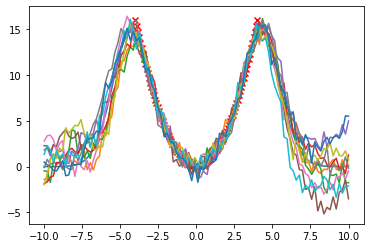

tf.Tensor(
[[ 1.00053299e-12  4.44089210e-16  0.00000000e+00 ... -6.61744490e-24
  -3.30872245e-24 -9.92616735e-24]
 [ 4.44089210e-16  1.00008890e-12  0.00000000e+00 ...  1.32348898e-23
   3.30872245e-23 -3.30872245e-24]
 [ 0.00000000e+00  0.00000000e+00  1.00008890e-12 ... -3.97046694e-23
  -1.32348898e-23 -6.61744490e-24]
 ...
 [ 0.00000000e+00 -1.32348898e-23 -5.29395592e-23 ...  9.99200722e-13
   4.44089210e-16 -1.77635684e-15]
 [-6.61744490e-24  0.00000000e+00  6.61744490e-24 ...  4.44089210e-16
   1.00053299e-12 -8.88178420e-16]
 [-6.61744490e-24  0.00000000e+00 -1.98523347e-23 ... -1.77635684e-15
  -8.88178420e-16  1.00097708e-12]], shape=(100, 100), dtype=float64)
tf.Tensor(
[1.00053299e-12 1.00008890e-12 1.00008890e-12 9.99644811e-13
 1.00008890e-12 1.00053299e-12 1.00053299e-12 1.00008890e-12
 1.00053299e-12 9.99644811e-13 1.00008890e-12 1.00008890e-12
 1.00008890e-12 1.00053299e-12 1.00008890e-12 1.00097708e-12
 1.00053299e-12 9.99200722e-13 9.98756633e-13 9.99644811e-13
 9.

In [20]:
prior_gp = vs['gp_var'] * GP((EQ() > vs['length_scale'])) + vs['noise_var'] * GP(Delta())
post_gp = prior_gp | (x, y)

xs = tf.convert_to_tensor(np.linspace(-10., 10., 100), dtype=tf.float64)
y_dist = post_gp(xs)

plt.scatter(x, y, color='r', marker='x')
plt.plot(xs, y_dist.mean)

for i in range(10):
    plt.plot(xs, y_dist.sample())

plt.show()

print(post_gp(x).var)
print(tf.linalg.diag_part(post_gp(x).var))

In [4]:
from boa.models.gp_model_v2 import GPModel

gpm = GPModel(kernel="rbf",
              num_optimizer_restarts=3)

gpm | (tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]))

print(gpm.xs)
print(gpm.ys)

tf.Tensor(
[[-2.        ]
 [-1.78947365]
 [-1.57894731]
 [-1.36842108]
 [-1.15789473]
 [-0.94736838]
 [-0.73684216]
 [-0.52631581]
 [-0.31578946]
 [-0.10526311]
 [ 0.10526323]
 [ 0.31578946]
 [ 0.52631569]
 [ 0.73684216]
 [ 0.94736838]
 [ 1.15789485]
 [ 1.36842108]
 [ 1.57894731]
 [ 1.78947377]
 [ 2.        ]], shape=(20, 1), dtype=float64)
tf.Tensor(
[[4.        ]
 [3.20221595]
 [2.49307459]
 [1.87257625]
 [1.34072021]
 [0.89750685]
 [0.54293636]
 [0.27700833]
 [0.09972298]
 [0.01108032]
 [0.01108035]
 [0.09972298]
 [0.2770082 ]
 [0.54293636]
 [0.89750685]
 [1.34072048]
 [1.87257625]
 [2.49307459]
 [3.20221638]
 [4.        ]], shape=(20, 1), dtype=float64)


In [5]:
gpm.train()

Optimization round: 1 / 3
assigned
-251.00057898182484
Optimization round: 2 / 3
Optimization round: 3 / 3


In [6]:
new_x = tf.constant([[5]], dtype=tf.float64)
new_y = new_x ** 2

gpm.add_true_point(new_x, new_y)

print(gpm.xs)
print(gpm.ys)

tf.Tensor(
[[-2.        ]
 [-1.78947365]
 [-1.57894731]
 [-1.36842108]
 [-1.15789473]
 [-0.94736838]
 [-0.73684216]
 [-0.52631581]
 [-0.31578946]
 [-0.10526311]
 [ 0.10526323]
 [ 0.31578946]
 [ 0.52631569]
 [ 0.73684216]
 [ 0.94736838]
 [ 1.15789485]
 [ 1.36842108]
 [ 1.57894731]
 [ 1.78947377]
 [ 2.        ]
 [ 5.        ]], shape=(21, 1), dtype=float64)
tf.Tensor(
[[4.00000000e+00]
 [3.20221595e+00]
 [2.49307459e+00]
 [1.87257625e+00]
 [1.34072021e+00]
 [8.97506854e-01]
 [5.42936362e-01]
 [2.77008330e-01]
 [9.97229838e-02]
 [1.10803232e-02]
 [1.10803483e-02]
 [9.97229838e-02]
 [2.77008205e-01]
 [5.42936362e-01]
 [8.97506854e-01]
 [1.34072048e+00]
 [1.87257625e+00]
 [2.49307459e+00]
 [3.20221638e+00]
 [4.00000000e+00]
 [2.50000000e+01]], shape=(21, 1), dtype=float64)


In [7]:
gpm.predict_batch(tf.constant([[3], [4]], dtype=tf.float64))

(<tf.Tensor: id=70170, shape=(2, 1), dtype=float64, numpy=
 array([[6.21443717],
        [8.42011986]])>,
 <tf.Tensor: id=70173, shape=(2,), dtype=float64, numpy=array([1.74384571, 1.85950446])>)

In [22]:
tf.stack((tf.constant([1, 2]), tf.constant([5, 6])), axis=0)

<tf.Tensor: id=439814, shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [5, 6]], dtype=int32)>